# 三维数据立方模拟（`cube3d`）

In [1]:
from gehong import spec1d as s
from gehong import map2d as m
from gehong import cube3d as b
from gehong import config as c
import numpy as np
import matplotlib.pyplot as plt

### 光谱格式配置项

`config`模块用来配置模拟光谱的格式，包括波长方向配置（波长范围、波长间隔）和空间方向配置（像素数、像素大小）。默认配置下模拟得到的三维数据立方可直接用于`csst-ifs-etc`的计算。

In [2]:
config = c.config()

## 模拟TNG星系的积分视场光谱

### 数据读取

In [3]:
from astropy.io import fits
hdulist = fits.open('TNG_Example.fits')
print(hdulist.info())

Filename: TNG_Example.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SURFACE_BRIGHT    1 ImageHDU         8   (30, 30)   float64   
  2  AGE_STAR      1 ImageHDU         8   (30, 30)   float64   
  3  FEH_STAR      1 ImageHDU         8   (30, 30)   float64   
  4  VEL_STAR      1 ImageHDU         8   (30, 30)   float64   
  5  SIG_STAR      1 ImageHDU         8   (30, 30)   float64   
  6  HA_FLUX       1 ImageHDU         8   (30, 30)   float64   
  7  ZH_GAS        1 ImageHDU         8   (30, 30)   float64   
  8  VEL_GAS       1 ImageHDU         8   (30, 30)   float64   
  9  SIG_GAS       1 ImageHDU         8   (30, 30)   float64   
None


### 分别导入数据

In [4]:
# 恒星星族相关Map
stellar_sbmap    = m.Map2d(config)
stellar_sbmap.load_map(hdulist[1].data)
stellar_agemap   = m.Map2d(config)
stellar_agemap.load_map(np.log10(hdulist[2].data*1e9))
stellar_fehmap   = m.Map2d(config)
stellar_fehmap.load_map(hdulist[3].data)
stellar_velmap   = m.Map2d(config)
stellar_velmap.load_map(hdulist[4].data)
stellar_vdispmap = m.Map2d(config)
stellar_vdispmap.load_map(hdulist[5].data)
# 气体相关Map
gas_hamap    = m.Map2d(config)
gas_hamap.load_map(hdulist[6].data)
gas_zhmap    = m.Map2d(config)
gas_zhmap.load_map(hdulist[7].data)
gas_velmap   = m.Map2d(config)
gas_velmap.load_map(hdulist[8].data)
gas_vdispmap = m.Map2d(config)
gas_vdispmap.load_map(hdulist[9].data)
# 假设一个尘埃消光分布
ebvmap = m.Map2d(config)
ebvmap.load_map(hdulist[5].data * 0 + 0.1)

stellarcontinuum = m.StellarPopulationMap(config, sbright = stellar_sbmap, 
                                          logage = stellar_agemap, feh = stellar_fehmap, 
                                          vel = stellar_velmap, vdisp = stellar_vdispmap, 
                                          ebv = ebvmap)
ionizedgas = m.IonizedGasMap(config, halpha = gas_hamap, 
                             zh = gas_zhmap, vel = gas_velmap, 
                             vdisp = gas_vdispmap, ebv = ebvmap)

### 配置cube3d的基本参数

模拟的数据立方类的形式进行操作（`cube3d.Cube3D`）。在开始模拟之前需先对模拟参数进行配置，包括数据立方的格式`config`，恒星成分物理参数分布`stellar_map`和气体成分物理参数分布`gas_map`

In [5]:
u = b.Cube3D(config, stellar_map = stellarcontinuum, gas_map = ionizedgas)

### 配置模拟光谱所需要的模板

包括恒星连续谱模板和电离气体发射线模板

In [6]:
gas_tem = s.EmissionLineTemplate(config, model = 'hii')
stellar_tem = s.StellarContinuumTemplate(config)

### 开始进行光谱模拟

In [7]:
u.make_cube(stellar_tem = stellar_tem, hii_tem = gas_tem)

### 展示模拟光谱

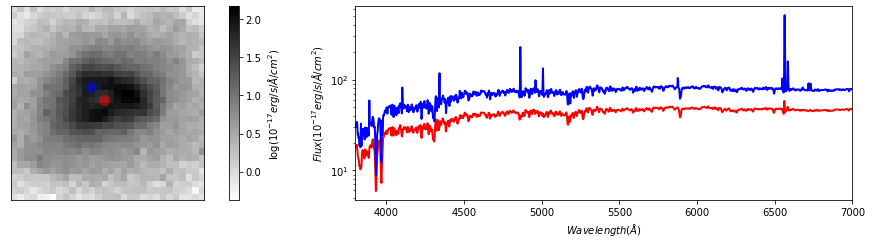

In [8]:
x1, y1 = 14, 14
x2, y2 = 12, 12

plt.figure(figsize=(15,3.5))
plt.subplot(121)
plt.imshow(np.log10(np.mean(u.flux[:,:,(u.wave>4900)&(u.wave<5100)],axis=2)),cmap='gray_r')
plt.colorbar(label=r'$\log (10^{-17} erg/s/\AA/cm^2)$')
plt.scatter(x1,y1,marker='o',s=100,color='red',alpha=0.5)
plt.scatter(x2,y2,marker='o',s=100,color='blue',alpha=0.5)
plt.xticks([])
plt.yticks([])

plt.subplot(122)
idx=(u.wave>3800)&(u.wave<7000)
plt.plot(u.wave[idx],u.flux[x1,y1,:][idx],lw=2,color='red')
plt.plot(u.wave[idx],u.flux[x2,y2,:][idx],lw=2,color='blue')
plt.xlim(3800,7000)
plt.yscale('log')
plt.xlabel(r'$Wavelength(\AA)$')
plt.ylabel(r'$Flux (10^{-17} erg/s/\AA/cm^2)$')

plt.tight_layout()
plt.show()

### 数据立方存储

In [9]:
u.savefits('result.fits')

AttributeError: 'Cube3D' object has no attribute 'inst'